In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import sys

In [2]:
all_data = pd.read_csv('data_for_model.csv')

In [3]:
# for 2016-17 season train on 2012-13 through 2015-16
training_seasons = [12, 13, 14, 15]
testing_season = 16

In [4]:
all_model_features = ['Period', 'StartScoreDifferential', 'Time', 'Putback', 'IsRegularSeason', 'SecondsSincePlayStarted', 'ShotDistance', 'ShotAngle', 'is_OffDeadball', 'is_OffFTMake', 'is_OffFTMiss', 'is_OffFTOreb', 'is_OffLiveBallTurnover', 'is_OffTeamBlockedOreb', 'is_OffTeamOreb', 'is_OffTimeout', 'is_OffBlockedOreb', 'is_OffBlock', 'is_OffMadeFG', 'is_OffOreb', 'is_OffMissedFG']

In [5]:
training_data = all_data[(all_data.Season.isin(training_seasons))]

at_rim = training_data[(training_data.ShotDistance < 5)]
non_rim_2pt = training_data[((training_data.ShotDistance >= 5) & (training_data.ShotValue == 2))]
jump_shots_3pt = training_data[((training_data.ShotValue == 3) & (training_data.ShotDistance < 35))]

at_rim_xgboost_model = XGBClassifier(
    random_state=909,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    min_child_weight=3
)

at_rim_catboost_classifier = CatBoostClassifier(
    bagging_temperature=1,
    rsm=0.1,
    learning_rate=0.1,
    depth=7,
    verbose=False, 
    random_seed=909
)

at_rim_pipe = Pipeline(
    [
        ('model', VotingClassifier(
            estimators=[
                ('xgb', at_rim_xgboost_model), 
                ('catboost', at_rim_catboost_classifier)
            ], 
            voting='soft'
        ))
    ]
)

at_rim_weights = [[1, 1]]

at_rim_param_grid = {
    'model__weights': at_rim_weights,
}

at_rim_grid = GridSearchCV(at_rim_pipe, cv=10, scoring='neg_log_loss', n_jobs=1, param_grid=at_rim_param_grid)

X_at_rim = at_rim[all_model_features]
y_at_rim = at_rim.Made

at_rim_grid.fit(X_at_rim.values, y_at_rim.values)
print('RA training log loss: %.4f' % at_rim_grid.best_score_)

non_rim_2pt_xgboost_model = XGBClassifier(
    random_state=909,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    min_child_weight=5
)

non_rim_2pt_catboost_classifier = CatBoostClassifier(
    bagging_temperature=1,
    rsm=0.1,
    learning_rate=0.04,
    depth=5,
    verbose=False, 
    random_seed=909
)

non_rim_2pt_pipe = Pipeline(
    [ 
        ('model', VotingClassifier(
            estimators=[
                ('xgb', non_rim_2pt_xgboost_model), 
                ('catboost', non_rim_2pt_catboost_classifier)
            ], 
            voting='soft'
        ))
    ]
)

non_rim_2pt_weights = [[1, 1]]

non_rim_2pt_param_grid = {
    'model__weights': non_rim_2pt_weights,
}

non_rim_2pt_grid = GridSearchCV(non_rim_2pt_pipe, cv=10, scoring='neg_log_loss', n_jobs=1, param_grid=non_rim_2pt_param_grid)

X_non_rim_2pt = non_rim_2pt[all_model_features]
y_non_rim_2pt = non_rim_2pt.Made

non_rim_2pt_grid.fit(X_non_rim_2pt.values, y_non_rim_2pt.values)
print('2pt non-RA training log loss: %.4f' % non_rim_2pt_grid.best_score_)

jump_shots_3pt_xgboost_model = XGBClassifier(
    random_state=909,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    min_child_weight=3
)

jump_shots_3pt_catboost_classifier = CatBoostClassifier(
    bagging_temperature=1,
    rsm=0.1,
    learning_rate=0.08,
    depth=5,
    verbose=False, 
    random_seed=909
)

jump_shots_3pt_pipe = Pipeline(
    [
        ('model', VotingClassifier(
            estimators=[
                ('xgb', jump_shots_3pt_xgboost_model), 
                ('catboost', jump_shots_3pt_catboost_classifier)
            ], 
            voting='soft'
        ))
    ]
)

jump_shots_3pt_weights = [[1, 1]]

jump_shots_3pt_param_grid = {
    'model__weights': jump_shots_3pt_weights,
}

jump_shots_3pt_grid = GridSearchCV(jump_shots_3pt_pipe, cv=10, scoring='neg_log_loss', n_jobs=1, param_grid=jump_shots_3pt_param_grid)

X_jump_shots_3pt = jump_shots_3pt[all_model_features]
y_jump_shots_3pt = jump_shots_3pt.Made

jump_shots_3pt_grid.fit(X_jump_shots_3pt.values, y_jump_shots_3pt.values)
print('3pt training log loss: %.4f' % jump_shots_3pt_grid.best_score_)

testing_data = all_data[(all_data.Season == testing_season)]

testing_at_rim = testing_data[(testing_data.ShotDistance < 5)]
testing_non_rim_2pt = testing_data[((testing_data.ShotDistance >= 5) & (testing_data.ShotValue == 2))]
testing_jump_shots_3pt = testing_data[((testing_data.ShotValue == 3) & (testing_data.ShotDistance < 35))]

X_test_at_rim = testing_at_rim[all_model_features]
y_test_at_rim = testing_at_rim.Made

X_test_non_rim_2pt = testing_non_rim_2pt[all_model_features]
y_test_non_rim_2pt = testing_non_rim_2pt.Made

X_test_jump_shots_3pt = testing_jump_shots_3pt[all_model_features]
y_test_jump_shots_3pt = testing_jump_shots_3pt.Made

at_rim_predictions = at_rim_grid.predict_proba(X_test_at_rim.values)
at_rim_predictions_df = pd.DataFrame(at_rim_predictions, columns=['miss','make'])
print("RA testing log loss: %.4f" % log_loss(y_test_at_rim, at_rim_predictions_df.make.values))

non_rim_2pt_predictions = non_rim_2pt_grid.predict_proba(X_test_non_rim_2pt.values)
non_rim_2pt_predictions_df = pd.DataFrame(non_rim_2pt_predictions, columns=['miss','make'])
print("2pt non-RA testing log loss: %.4f" % log_loss(y_test_non_rim_2pt, non_rim_2pt_predictions_df.make.values))

jump_shot_3pt_predictions = jump_shots_3pt_grid.predict_proba(X_test_jump_shots_3pt.values)
jump_shot_3pt_predictions_df = pd.DataFrame(jump_shot_3pt_predictions, columns=['miss','make'])
print("3pt testing log loss: %.4f" % log_loss(y_test_jump_shots_3pt, jump_shot_3pt_predictions_df.make.values))

test_prediction_df = pd.concat([at_rim_predictions_df, non_rim_2pt_predictions_df, jump_shot_3pt_predictions_df], ignore_index=True)
y_test = pd.concat([y_test_at_rim, y_test_non_rim_2pt, y_test_jump_shots_3pt])
print("All shots testing log loss: %.4f" % log_loss(y_test, test_prediction_df.make.values))

RA training log loss: -0.6247
2pt non-RA training log loss: -0.6685
3pt training log loss: -0.6486
RA testing log loss: 0.6197
2pt non-RA testing log loss: 0.6739
3pt testing log loss: 0.6503
All shots testing log loss: 0.6478


### Feature Importance with SHAP Values

In [6]:
import shap
shap.initjs()

In [7]:
xgb_3pt_model = jump_shots_3pt_grid.best_estimator_.named_steps['model'].estimators_[0]

xgb_3pt_explainer = shap.TreeExplainer(xgb_3pt_model)
xgb_3pt_shap_values = xgb_3pt_explainer.shap_values(X_test_jump_shots_3pt.values)

In [8]:
catboost_3pt_model = jump_shots_3pt_grid.best_estimator_.named_steps['model'].estimators_[1]

catboost_3pt_explainer = shap.TreeExplainer(catboost_3pt_model)
catboost_3pt_shap_values = catboost_3pt_explainer.shap_values(X_test_jump_shots_3pt.values)

In [9]:
# elementwise mean of shap values for each model to get shap values for ensemble per - https://github.com/slundberg/shap/issues/112
shap_values_3pt = np.mean([catboost_3pt_shap_values, xgb_3pt_shap_values], axis=0)
mean_ev_3pt = np.mean([xgb_3pt_explainer.expected_value, catboost_3pt_explainer.expected_value])

In [10]:
max_index_3pt = jump_shot_3pt_predictions_df.make.idxmax()

In [11]:
jump_shot_3pt_predictions_df.iloc[max_index_3pt]

miss    0.41225
make    0.58775
Name: 43539, dtype: float64

In [12]:
# visualize the max prediction's explanation - link='logit' shows probability values above graph
shap.force_plot(mean_ev_3pt, shap_values_3pt[max_index_3pt,:], X_test_jump_shots_3pt.iloc[max_index_3pt,:], link='logit')

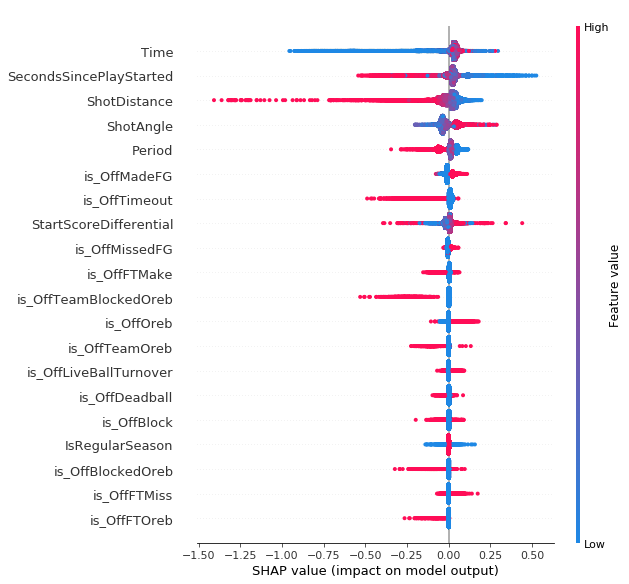

In [13]:
shap.summary_plot(shap_values_3pt, X_test_jump_shots_3pt.values, feature_names=all_model_features)

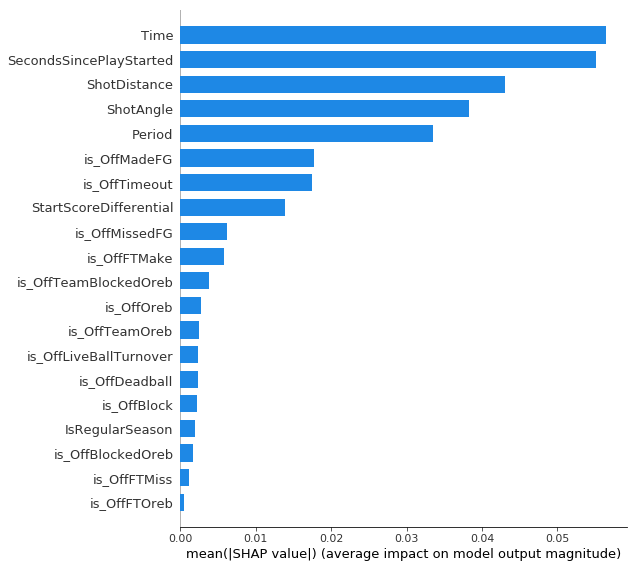

In [14]:
shap.summary_plot(shap_values_3pt, X_test_jump_shots_3pt.values, plot_type="bar", feature_names=all_model_features)

In [15]:
xgb_2pt_non_rim_model = non_rim_2pt_grid.best_estimator_.named_steps['model'].estimators_[0]

xgb_2pt_non_rim_explainer = shap.TreeExplainer(xgb_2pt_non_rim_model)
xgb_2pt_non_rim_shap_values = xgb_2pt_non_rim_explainer.shap_values(X_test_non_rim_2pt.values)

catboost_2pt_non_rim_model = non_rim_2pt_grid.best_estimator_.named_steps['model'].estimators_[1]

catboost_2pt_non_rim_explainer = shap.TreeExplainer(catboost_2pt_non_rim_model)
catboost_2pt_non_rim_shap_values = catboost_2pt_non_rim_explainer.shap_values(X_test_non_rim_2pt.values)

# elementwise mean of shap values for each model to get shap values for ensemble per - https://github.com/slundberg/shap/issues/112
shap_values_2pt_non_rim = np.mean([catboost_2pt_non_rim_shap_values, xgb_2pt_non_rim_shap_values], axis=0)
mean_ev_2pt_non_rim = np.mean([xgb_2pt_non_rim_explainer.expected_value, catboost_2pt_non_rim_explainer.expected_value])

max_index_2pt_non_rim = non_rim_2pt_predictions_df.make.idxmax()

non_rim_2pt_predictions_df.iloc[max_index_2pt_non_rim]

miss    0.396427
make    0.603573
Name: 15281, dtype: float64

In [16]:
shap.force_plot(mean_ev_2pt_non_rim, shap_values_2pt_non_rim[max_index_2pt_non_rim,:], X_test_non_rim_2pt.iloc[max_index_2pt_non_rim,:], link='logit')

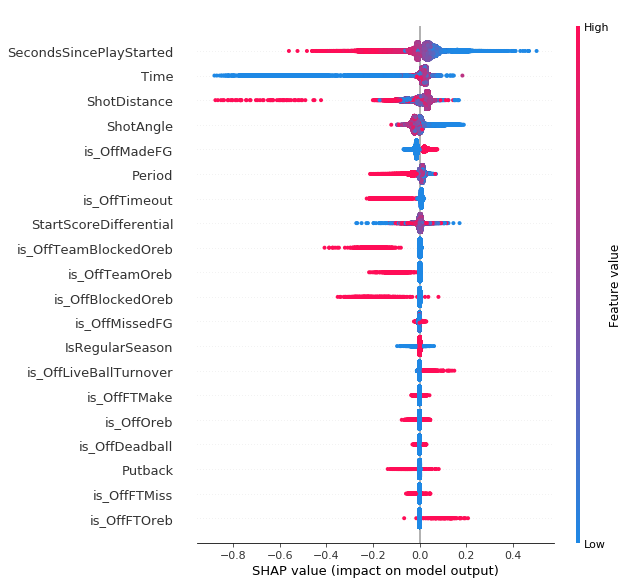

In [17]:
shap.summary_plot(shap_values_2pt_non_rim, X_test_non_rim_2pt.values, feature_names=all_model_features)

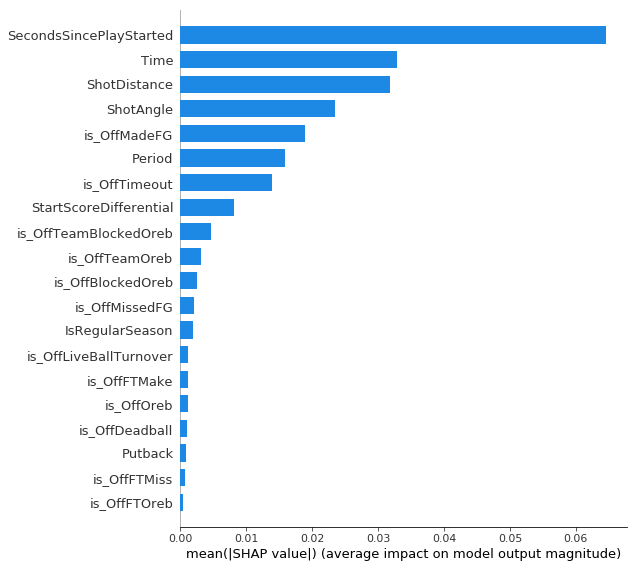

In [18]:
shap.summary_plot(shap_values_2pt_non_rim, X_test_non_rim_2pt.values, plot_type="bar", feature_names=all_model_features)

In [19]:
xgb_at_rim_model = at_rim_grid.best_estimator_.named_steps['model'].estimators_[0]

xgb_at_rim_explainer = shap.TreeExplainer(xgb_at_rim_model)
xgb_at_rim_shap_values = xgb_at_rim_explainer.shap_values(X_test_at_rim.values)

catboost_at_rim_model = at_rim_grid.best_estimator_.named_steps['model'].estimators_[1]

catboost_at_rim_explainer = shap.TreeExplainer(catboost_at_rim_model)
catboost_at_rim_shap_values = catboost_at_rim_explainer.shap_values(X_test_at_rim.values)

# elementwise mean of shap values for each model to get shap values for ensemble per - https://github.com/slundberg/shap/issues/112
shap_values_at_rim = np.mean([xgb_at_rim_shap_values, catboost_at_rim_shap_values], axis=0)
mean_ev_at_rim = np.mean([xgb_at_rim_explainer.expected_value, catboost_at_rim_explainer.expected_value])

max_index_at_rim = at_rim_predictions_df.make.idxmax()

at_rim_predictions_df.iloc[max_index_at_rim]

miss    0.017759
make    0.982241
Name: 51120, dtype: float64

In [20]:
shap.force_plot(mean_ev_at_rim, shap_values_at_rim[max_index_at_rim,:], X_test_at_rim.iloc[max_index_at_rim,:], link='logit')

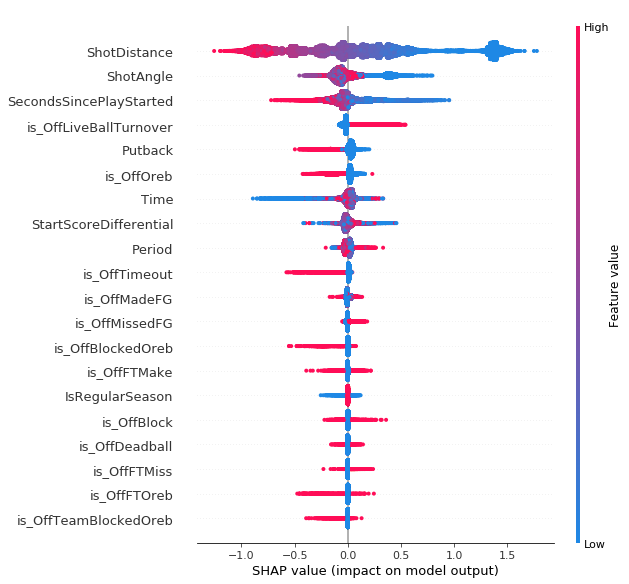

In [21]:
shap.summary_plot(shap_values_at_rim, X_test_at_rim.values, feature_names=all_model_features)

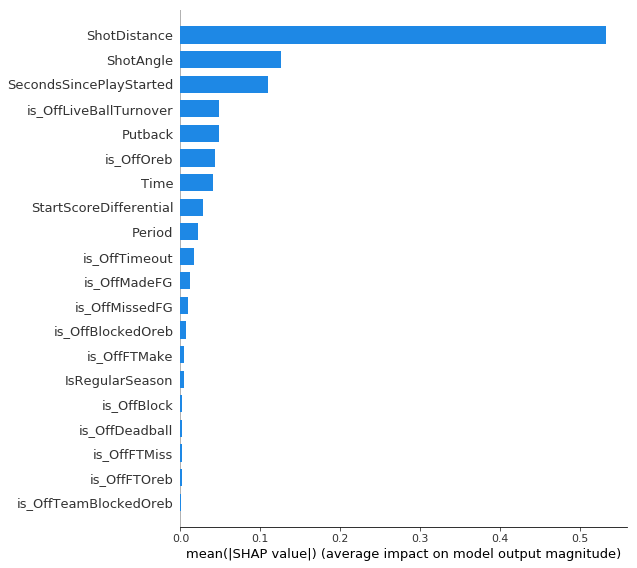

In [22]:
shap.summary_plot(shap_values_at_rim, X_test_at_rim.values, plot_type="bar", feature_names=all_model_features)

In [23]:
print(pd.__version__)

0.23.3


In [24]:
print(np.__version__)

1.14.5


In [25]:
import sklearn
print(sklearn.__version__)

0.19.2


In [26]:
import catboost
print(catboost.__version__)

0.9.1.1


In [27]:
import xgboost
print(xgboost.__version__)

0.72.1


In [28]:
print(sys.version_info)

sys.version_info(major=3, minor=6, micro=1, releaselevel='final', serial=0)
